In [4]:
from collections import Counter
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import codecs

In [5]:
with open('poslo.txt', encoding="utf8") as f:
    lines = f.readlines()

In [6]:
lines[0]

'А где щи, тут и нас ищи.\n'

In [7]:
def preprocess(line):
    return ' '.join(w.lower() for w in (''.join(ch for ch in word if ch.isalpha()) for word in line.split()) if w)

In [8]:
preprocess(lines[0])

'а где щи тут и нас ищи'

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        lines,
    ):
        self.lines = lines
        self.pad_token = '<PAD>'
        self.bos_token = '<BOS>'
        self.eos_token = '<EOS>'
        self.uniq_words = [self.pad_token, self.bos_token, self.eos_token] + self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.pad_token_id = self.word_to_index['<PAD>']
        self.bos_token_id = self.word_to_index['<BOS>']
        self.eos_token_id = self.word_to_index['<EOS>']

        self.tokenized = [[self.word_to_index[w] for w in line.split()] for line in self.lines]

    def get_uniq_words(self):
        word_counts = Counter(word for line in self.lines for word in line.split())
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, index):
        return (
            torch.LongTensor([self.bos_token_id] + self.tokenized[index]),
            torch.LongTensor(self.tokenized[index] + [self.eos_token_id]),
        )

In [10]:
dataset = Dataset([preprocess(line) for line in lines])

In [11]:
dataset[0]

(tensor([  1,   4,  25, 310, 197,   5,  56, 311]),
 tensor([  4,  25, 310, 197,   5,  56, 311,   2]))

In [12]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=dataset.pad_token_id)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=dataset.pad_token_id)

    return xx_pad, yy_pad, x_lens, y_lens

In [13]:
dataloader = DataLoader(dataset, batch_size=512, collate_fn=pad_collate, shuffle=True)

In [14]:
class Model(nn.Module):
    def __init__(self, vocab_len):
        super(Model, self).__init__()
        self.hidden_size = 256
        self.embedding_dim = 256
        self.num_layers = 3

        vocab_len = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_len,
            embedding_dim=self.embedding_dim,
            padding_idx=0,
        )
        self.rnn = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True,
        )
        self.fc = nn.Linear(self.hidden_size, vocab_len)

    def forward(self, x, lens=None, prev_state=None):
        embed = self.embedding(x)
        if lens is None:
            output, state = self.rnn(embed, prev_state)
        else:
            embed_packed = pack_padded_sequence(embed, lens, batch_first=True, enforce_sorted=False)
            output_packed, state = self.rnn(embed_packed, prev_state)
            output, _ = pad_packed_sequence(output_packed, batch_first=True)
        logits = self.fc(output)
        return logits, state

In [15]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(len(dataset.uniq_words)).to(DEVICE).train()

In [16]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

5319291

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [18]:
def train(model, dataloader, criterion, optimizer, epochs):
    losses = []
    model.train()

    for epoch in range(epochs):
        for x, y, x_lens, y_lens in dataloader:
            optimizer.zero_grad()

            y_pred, _ = model(x.to(DEVICE), x_lens)
            loss = criterion(y_pred.transpose(1, 2), y.to(DEVICE))

            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        if epoch % 10 == 0:
            print({ 'epoch': epoch, 'loss': losses[-1] })

    return losses

In [19]:
loss_history = train(model, dataloader, criterion, optimizer, epochs=250)

{'epoch': 0, 'loss': 7.377316474914551}
{'epoch': 10, 'loss': 6.221266269683838}
{'epoch': 20, 'loss': 5.7292375564575195}
{'epoch': 30, 'loss': 5.315099239349365}
{'epoch': 40, 'loss': 4.718502521514893}
{'epoch': 50, 'loss': 4.299665451049805}
{'epoch': 60, 'loss': 3.903717041015625}
{'epoch': 70, 'loss': 3.482243776321411}
{'epoch': 80, 'loss': 3.0355379581451416}
{'epoch': 90, 'loss': 2.7317733764648438}
{'epoch': 100, 'loss': 2.4760231971740723}
{'epoch': 110, 'loss': 2.2514090538024902}
{'epoch': 120, 'loss': 2.0736277103424072}
{'epoch': 130, 'loss': 1.8672949075698853}
{'epoch': 140, 'loss': 1.7959599494934082}
{'epoch': 150, 'loss': 1.6400595903396606}
{'epoch': 160, 'loss': 1.5234030485153198}
{'epoch': 170, 'loss': 1.5439362525939941}
{'epoch': 180, 'loss': 1.4565234184265137}
{'epoch': 190, 'loss': 1.3894922733306885}
{'epoch': 200, 'loss': 1.4020274877548218}
{'epoch': 210, 'loss': 1.372261881828308}
{'epoch': 220, 'loss': 1.3907551765441895}
{'epoch': 230, 'loss': 1.28211

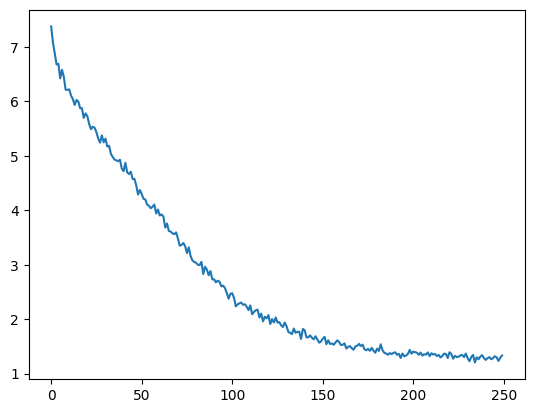

In [20]:
plt.plot(loss_history)

In [21]:
def tokenize(value):
    return [dataset.bos_token_id]+[dataset.word_to_index[word.lower()] for word in value.split()]


def decode(token_ids):
    return ' '.join(dataset.index_to_word[token_id] for token_id in token_ids)


@torch.no_grad()
def generate(prompt, max_tokens=20):
    model.eval()
    response = []
    state = None
    prompt_tokens = tokenize(prompt)
    model_input = torch.LongTensor([prompt_tokens]).to(DEVICE)
    for _ in range(max_tokens):
        logits, state = model(model_input, prev_state=state)
        token_argmax = logits[0, -1].argmax()
        response.append(token_argmax.item())
        if response[-1] == dataset.eos_token_id:
            break
        model_input = token_argmax.view(1, 1)

    return decode(prompt_tokens + response)

In [22]:
generate('рука')

'<BOS> рука руку моет а две руки лицо <EOS>'

In [23]:
@torch.no_grad()
def sample(prompt, max_tokens=20):
    model.eval()
    response = []
    state = None
    prompt_tokens = tokenize(prompt)
    model_input = torch.LongTensor([prompt_tokens]).to(DEVICE)
    for _ in range(max_tokens):
        logits, state = model(model_input, prev_state=state)
        token_probs = F.softmax(logits[0, -1], dim=-1).cpu().numpy()
        sampled_token = np.random.choice(len(token_probs), p=token_probs)
        response.append(sampled_token)
        if response[-1] == dataset.eos_token_id:
            break
        model_input = torch.LongTensor([[sampled_token]]).to(DEVICE)

    return decode(prompt_tokens + response)

In [24]:
sample('без')

'<BOS> без мужа в беде головы сам в аптека не годится <EOS>'

In [5]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB 330.3 kB/s eta 0:00:06
    --------------------------------------- 0.0/1.7 MB 393.8 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.7 MB 655.4 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/1.7 MB 833.5 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.7 MB 1.1 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 1.0 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 1.0 MB/s eta 0:00:02
   ---------- ----------------------------- 0.5/1.7 MB 1.3 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.7 MB 1.2 MB/s eta 0:00:02
   ------------- -------------------------- 0.6/1.7 MB 1.2 MB/s eta 0:00:01
   --------------- ------------------------ 0.7/1.7 MB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.7 MB 1.3 MB/s eta 0:00:01
   --------

In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5Tokenizer, RobertaTokenizer

tokenizer = T5Tokenizer.from_pretrained("ai-forever/ruT5-large")

OSError: Unable to load vocabulary from file. Please check that the provided vocabulary is accessible and not corrupted.

In [6]:
# ruT5-base example

from transformers import pipeline

generator = pipeline("text2text-generation", model="sberbank-ai/ruT5-base")
generator(
    "Текст: С мая 2021 в России "
)

# ruT5-large example 
from transformers import T5ForConditionalGeneration,T5Tokenizer

model=T5ForConditionalGeneration.from_pretrained('sberbank-ai/ruT5-large')

tokenizer=T5Tokenizer.from_pretrained('sberbank-ai/ruT5-large',)
input_ids = tokenizer('Снижение цен <extra_id_0> в Москве возможно только при <extra_id_1>. Это условие названо в аналитической заметке агентства <extra_id_2>, поступившей в редакцию <extra_id_3>', return_tensors='pt').input_ids

out_ids=model.generate(input_ids=input_ids,
                        max_length=30,
                        eos_token_id=tokenizer.eos_token_id, 
                        early_stopping=True)

tokenizer.decode(out_ids[0][1:])

#<extra_id_0> на бензин<extra_id_1> условии сохранения текущей ситуации<extra_id_2> ТАСС<extra_id_3>.</s>


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

OSError: Unable to load vocabulary from file. Please check that the provided vocabulary is accessible and not corrupted.

In [2]:
len(dataset.uniq_words)

NameError: name 'dataset' is not defined

In [43]:
len(set(((
    x for tokens in (
        tokenizer(
            preprocess(line),
            add_special_tokens=False,
        )['input_ids'] for line in lines
    ) for x in tokens
))))

NameError: name 'tokenizer' is not defined